<a href="https://colab.research.google.com/github/rizqyjoe/Facial_Expression_Recognition_CNN_VGG16/blob/main/Model%205/1_57%25_Acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://www.kaggle.com/vipinochiramani/notebook7e83fcd07e

In [2]:
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/fer2013 dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/drive/MyDrive/Dataset/fer2013 dataset/example_submission.csv
/content/drive/MyDrive/Dataset/fer2013 dataset/fer2013.tar.gz
/content/drive/MyDrive/Dataset/fer2013 dataset/icml_face_data.csv
/content/drive/MyDrive/Dataset/fer2013 dataset/test.csv
/content/drive/MyDrive/Dataset/fer2013 dataset/train.csv
/content/drive/MyDrive/Dataset/fer2013 dataset/dataset/test-private.zip
/content/drive/MyDrive/Dataset/fer2013 dataset/dataset/test-public.zip
/content/drive/MyDrive/Dataset/fer2013 dataset/dataset/train.zip
/content/drive/MyDrive/Dataset/fer2013 dataset/fer2013/fer2013.csv
/content/drive/MyDrive/Dataset/fer2013 dataset/fer2013/README
/content/drive/MyDrive/Dataset/fer2013 dataset/fer2013/fer2013.bib


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical

In [4]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/fer2013 dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Dataset/fer2013 dataset/example_submission.csv
/content/drive/MyDrive/Dataset/fer2013 dataset/fer2013.tar.gz
/content/drive/MyDrive/Dataset/fer2013 dataset/icml_face_data.csv
/content/drive/MyDrive/Dataset/fer2013 dataset/test.csv
/content/drive/MyDrive/Dataset/fer2013 dataset/train.csv
/content/drive/MyDrive/Dataset/fer2013 dataset/dataset/test-private.zip
/content/drive/MyDrive/Dataset/fer2013 dataset/dataset/test-public.zip
/content/drive/MyDrive/Dataset/fer2013 dataset/dataset/train.zip
/content/drive/MyDrive/Dataset/fer2013 dataset/fer2013/fer2013.csv
/content/drive/MyDrive/Dataset/fer2013 dataset/fer2013/README
/content/drive/MyDrive/Dataset/fer2013 dataset/fer2013/fer2013.bib


In [5]:
path='/content/drive/MyDrive/Dataset/fer2013 dataset/'
data=pd.read_csv(path+'icml_face_data.csv')

In [6]:
data

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [7]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [8]:
data[' Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name:  Usage, dtype: int64

In [9]:
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [10]:
emotions={0:'Angry' , 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise',6: 'Neutral'}

In [11]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [12]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [13]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [14]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [15]:
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(80, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

In [16]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number])
    axs[1].grid()
    
    plt.show()

In [17]:
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index())
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

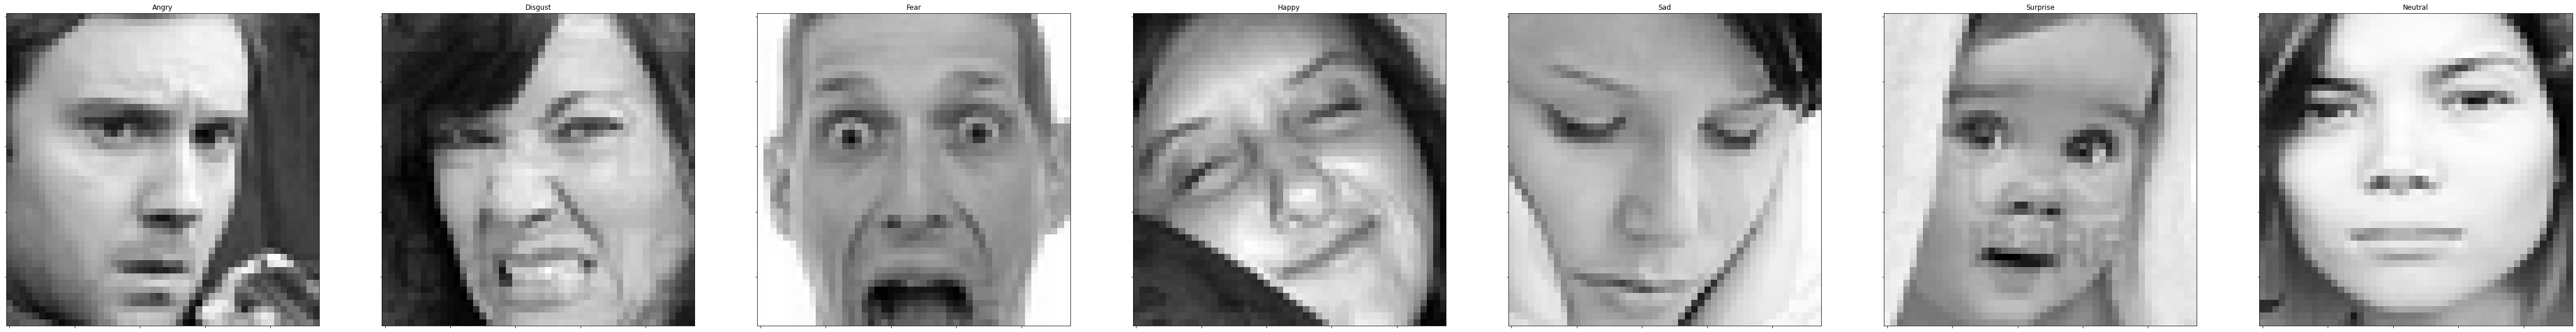

In [18]:
plot_all_emotions()

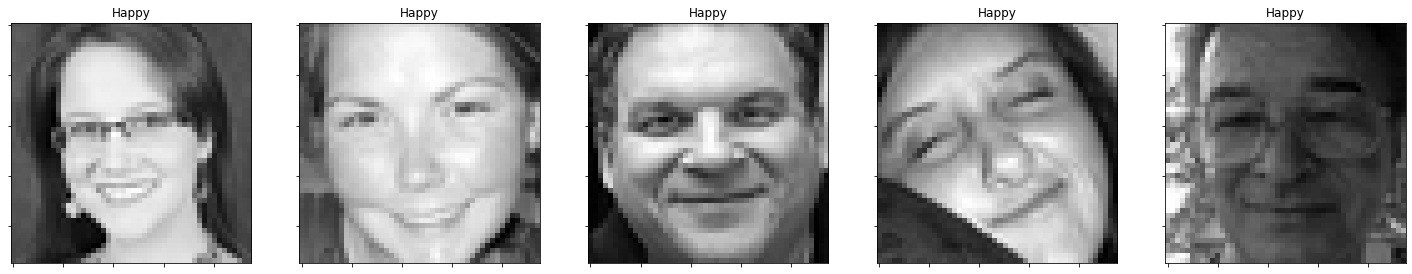

In [19]:
plot_examples(3)

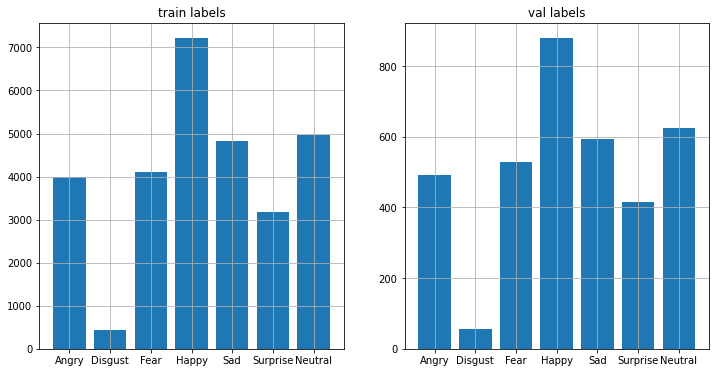

In [20]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [21]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [22]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

Model

In [ ]:
#model.add(Conv2D(32, (3, 3), padding="same", activation="relu",input_shape=(48, 48, 1)))
#model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Conv2D(128, (5, 5), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
#model.add(Flatten())
#model.add(Dense(64, activation='relu'))
#model.add(Dense(7, activation='softmax'))

In [27]:
model=models.Sequential()

model.add(Conv2D(input_shape=(48,48,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(7, activation = "softmax"))

In [28]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 256)      

In [30]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=30,
                    batch_size=64)

Epoch 1/30
449/449 [==============================] - 62s 62ms/step - loss: 0.2983 - accuracy: 0.2434 - val_loss: 4.2807 - val_accuracy: 0.1159
Epoch 2/30
449/449 [==============================] - 27s 60ms/step - loss: 0.2859 - accuracy: 0.2546 - val_loss: 144.1693 - val_accuracy: 0.1159
Epoch 3/30
449/449 [==============================] - 27s 60ms/step - loss: 0.2776 - accuracy: 0.2800 - val_loss: 103.7709 - val_accuracy: 0.1744
Epoch 4/30
449/449 [==============================] - 27s 59ms/step - loss: 0.2553 - accuracy: 0.3418 - val_loss: 61.1873 - val_accuracy: 0.2449
Epoch 5/30
449/449 [==============================] - 27s 59ms/step - loss: 0.2389 - accuracy: 0.3809 - val_loss: 10.1097 - val_accuracy: 0.2449
Epoch 6/30
449/449 [==============================] - 27s 60ms/step - loss: 0.2274 - accuracy: 0.4069 - val_loss: 8.1051 - val_accuracy: 0.1376
Epoch 7/30
449/449 [==============================] - 27s 60ms/step - loss: 0.2230 - accuracy: 0.4182 - val_loss: 120.7681 - val_a

In [31]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 2s 12ms/step - loss: 2.9988 - accuracy: 0.2597
test caccuracy: 0.2596823573112488


In [32]:
pred_test_labels = model.predict(test_images)

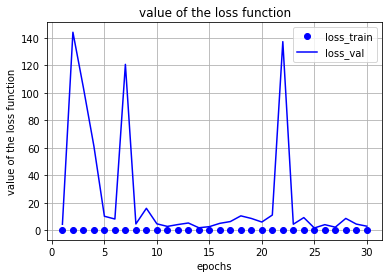

In [33]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

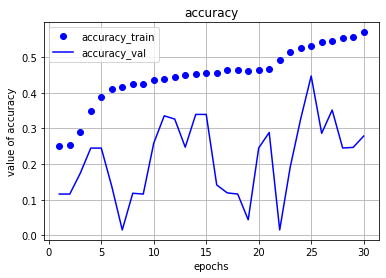

In [34]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

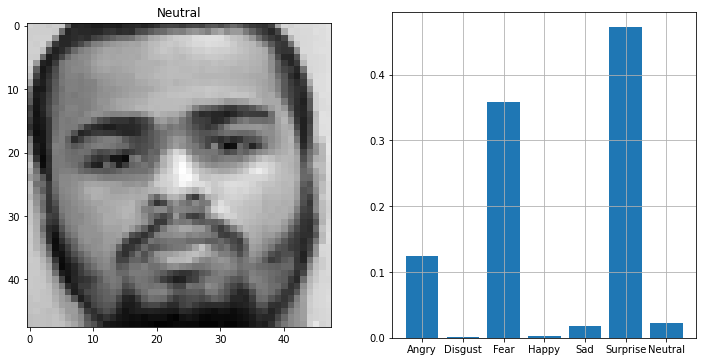

In [35]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)

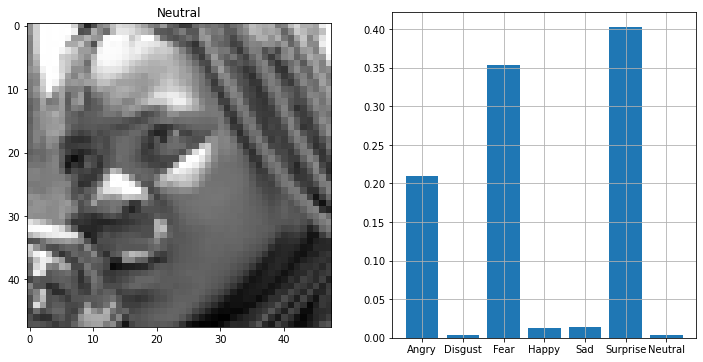

In [36]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 69)

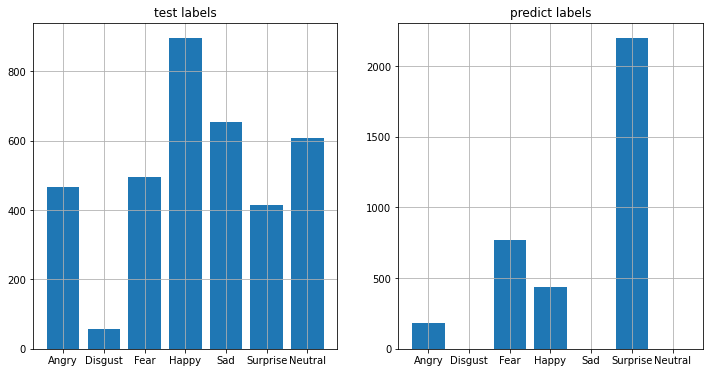

In [37]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

In [38]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

In [39]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

TypeError: ignored

In [ ]:
pd.read_csv(path+'example_submission.csv')

In [ ]:
test_data_output=pd.read_csv(path+'test.csv')

In [ ]:
test_output_image_array = np.zeros(shape=(len(test_data_output), 48, 48))

    
for i, row in enumerate(test_data_output.index):
    image = np.fromstring(test_data_output.loc[row, 'pixels'], dtype=int, sep=' ')
    image = np.reshape(image, (48, 48))
    test_output_image_array[i] = image

In [ ]:
test_output_image = test_output_image_array.reshape((test_output_image_array.shape[0], 48, 48, 1))
test_output_image = test_output_image.astype('float32')/255

In [ ]:
test_output_image_array.shape[0]

In [ ]:
# predict results
results = model.predict(test_output_image)

# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="3")


results.to_csv("challenges-in-representation-learning-facial-expression-recognition-challenge_submission.csv",index=False)